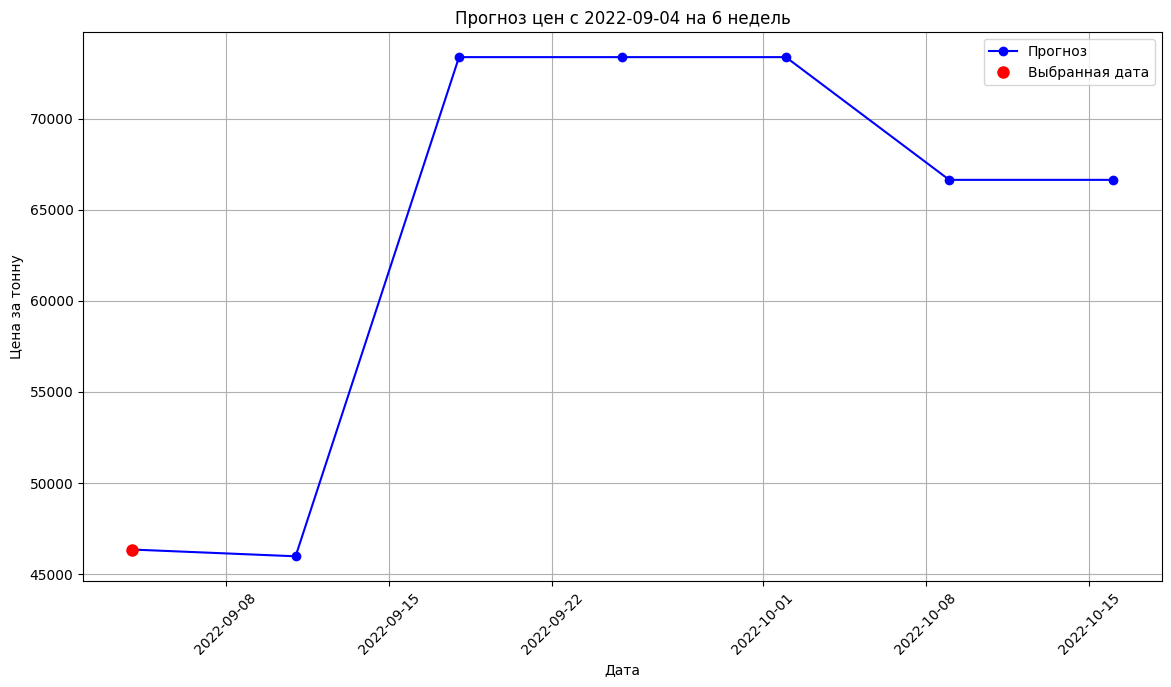

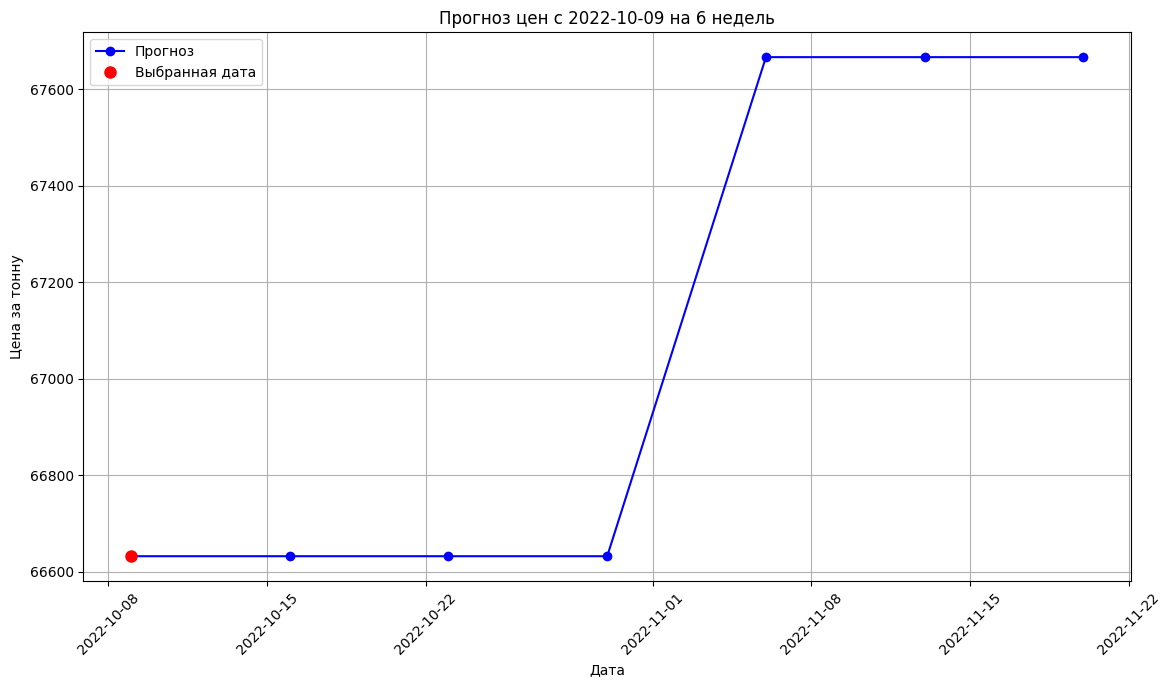

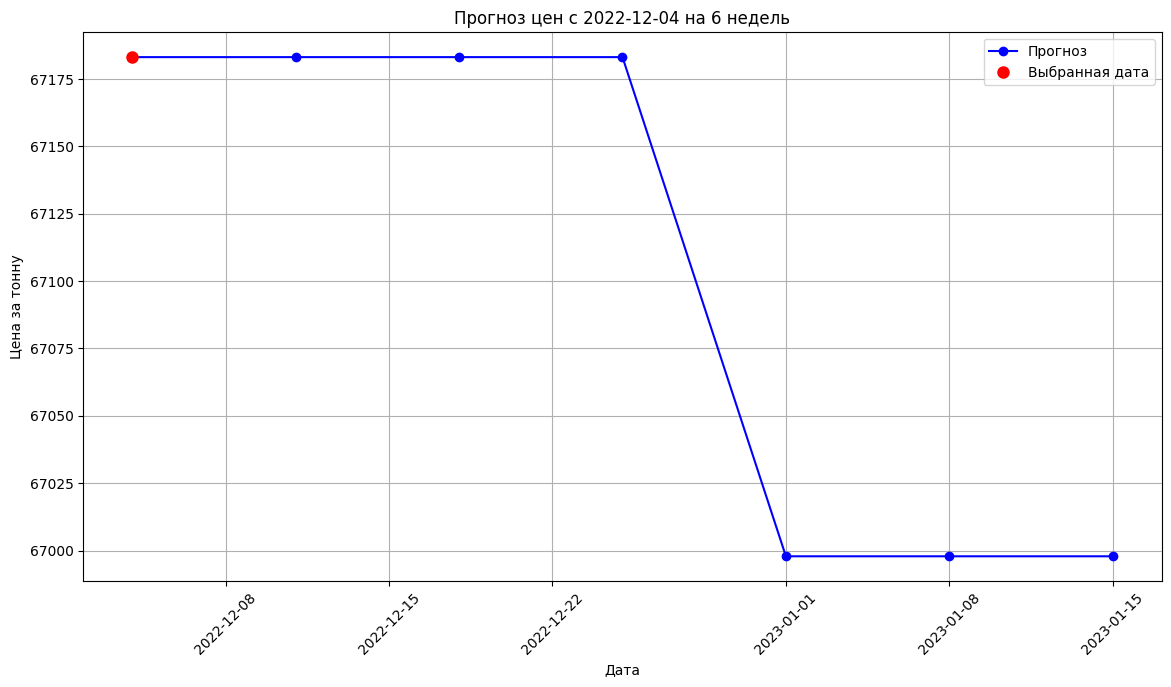

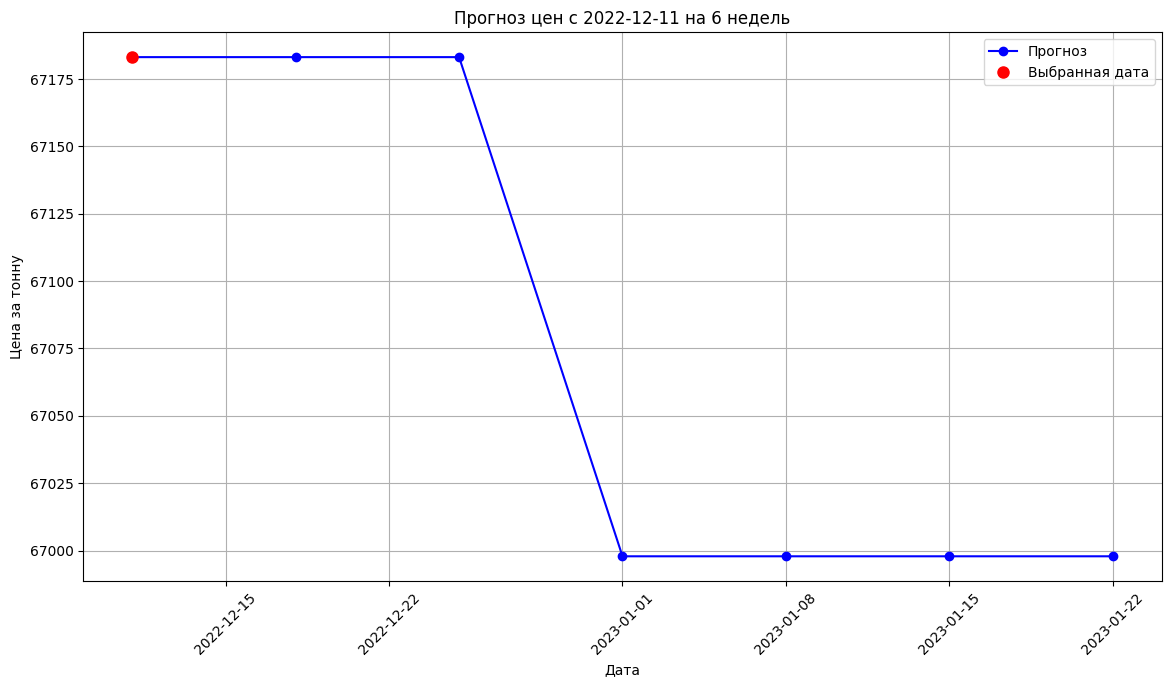

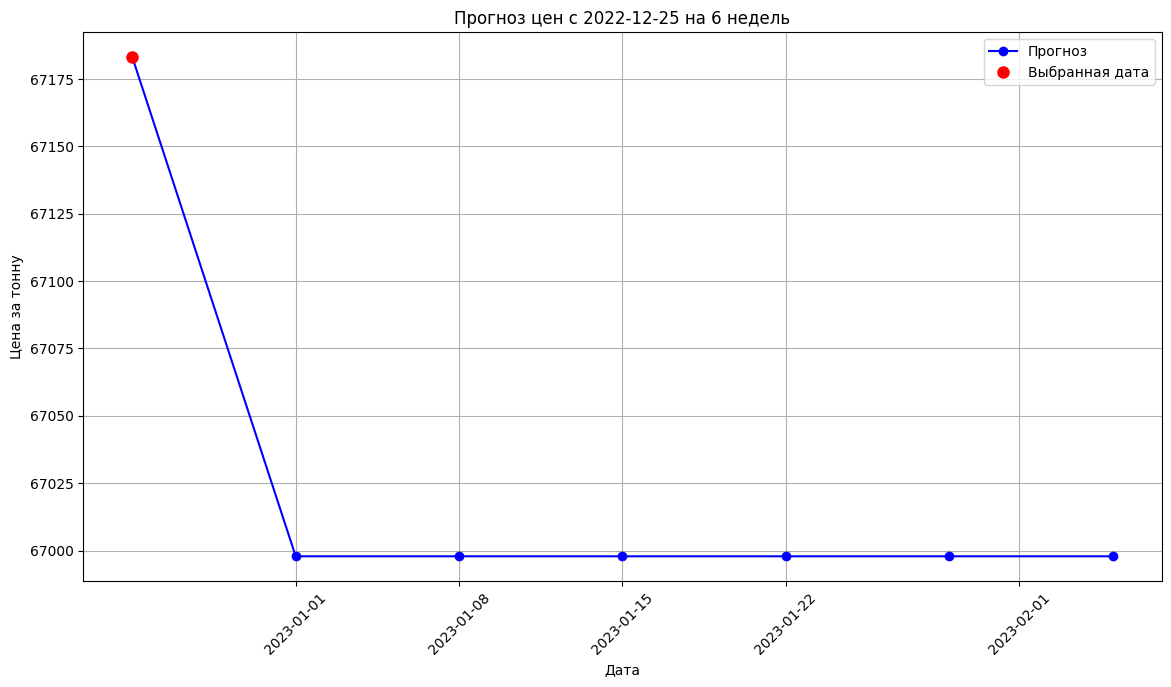

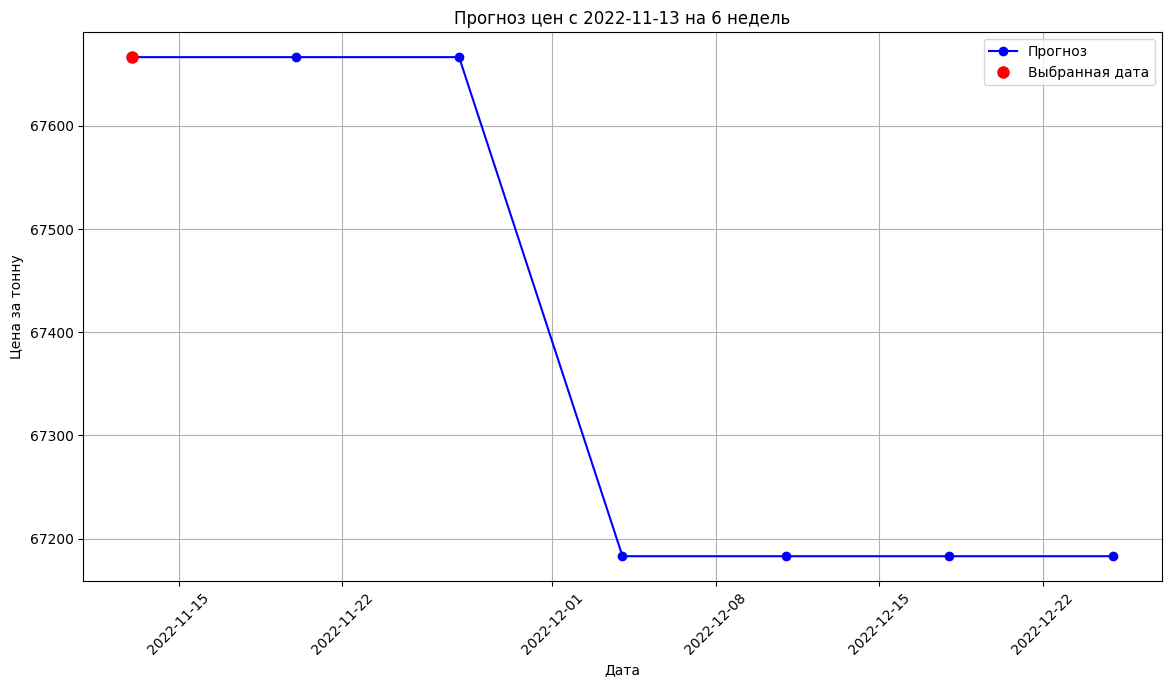

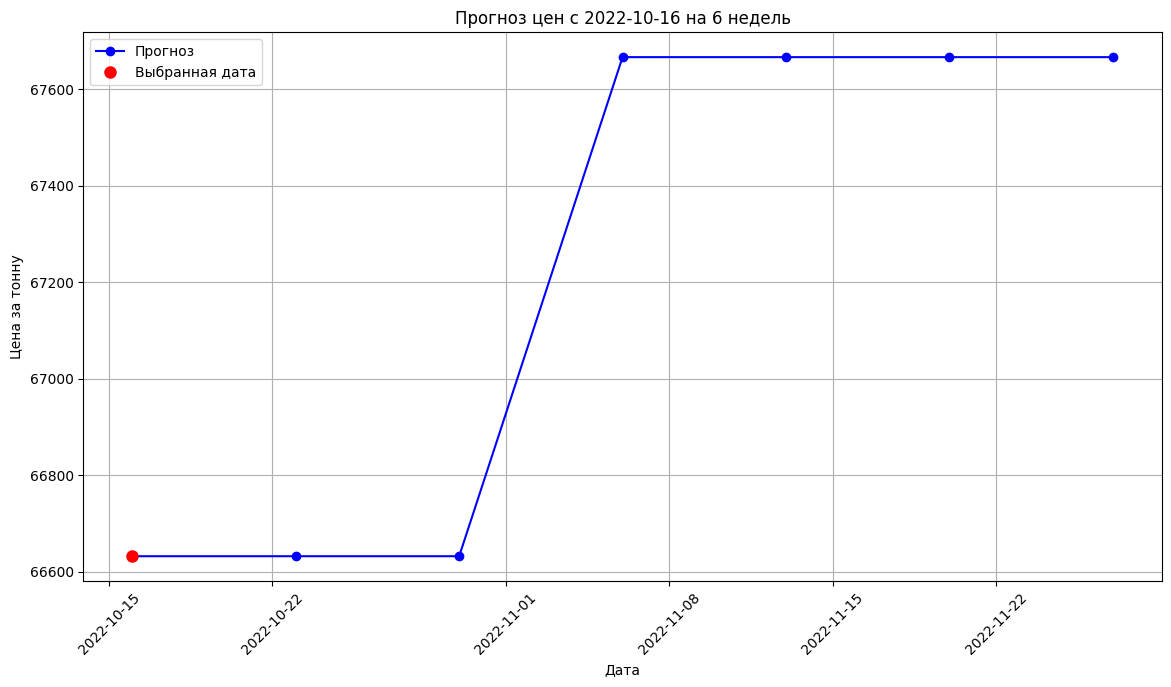

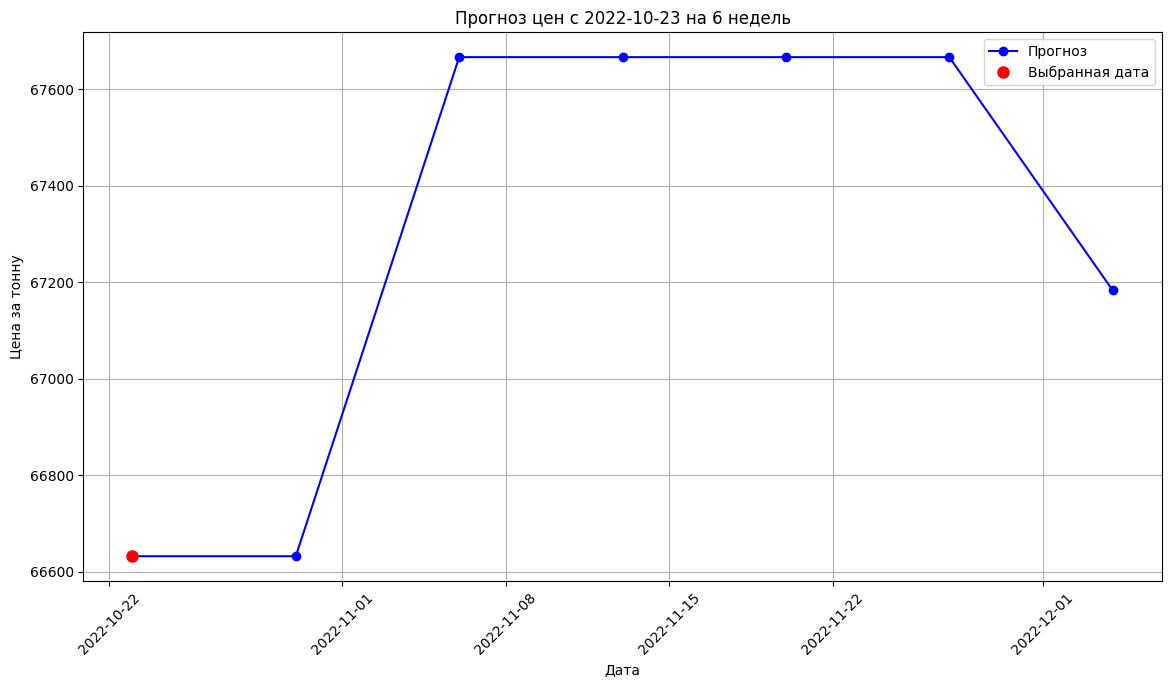

In [2]:
# импортируем все нам необходимые библиотеки
import tkinter as tk
from tkinter import ttk, messagebox
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from datetime import datetime
import numpy as np
from xgboost import XGBRegressor
import os
import warnings
warnings.filterwarnings('ignore') # игнорируем предуприждения

# Загружаем выданные нам данные
def load_real_data():
    try:
        data = pd.read_excel("train.xlsx", parse_dates=["dt"], index_col="dt")
        data.columns = ["price"]
        return data
    except Exception as e:
        messagebox.showerror("Ошибка", f"Ошибка загрузки данных: {str(e)}")
        return pd.DataFrame()

# Фунция которая делает прогноз
def generate_forecast():
    try:
        def create_features(df):
            features = df.copy()
 # добовление лагов
            for lag in [1, 2, 4, 8, 12]:
                features[f'lag_{lag}'] = features['price'].shift(lag)
            features['rolling_mean_4'] = features['price'].rolling(4).mean()
            features['rolling_std_12'] = features['price'].rolling(12).std()
 # Добавление временных признаков
            features['month'] = features.index.month
            features['year'] = features.index.year
            return features.dropna()

        data_for_prediction = real_data.copy()
        data_feat = create_features(data_for_prediction)
        required_features = ['lag_1', 'lag_2', 'lag_4', 'lag_8', 'lag_12', 
                           'rolling_mean_4', 'rolling_std_12', 'month', 'year']
        

 # Разделение на признаки и целевую переменную
        X = data_feat[required_features]
        y = data_feat['price']
 # Делаем модельку и настраеваем ее
        xgb_model = XGBRegressor(
            n_estimators=500,
            max_depth=6,
            learning_rate=0.01,
            random_state=42
        )
        xgb_model.fit(X, y)
# создание дат на будующие 30 дней :)
        last_date = real_data.index[-1]
        weeks_to_forecast = 30
        future_dates = pd.date_range(last_date, periods=weeks_to_forecast, freq='W')
        future_data = pd.DataFrame(index=future_dates)
        last_values = real_data.tail(12).copy()

# Создание признаков для будущих периодов
        for i in range(weeks_to_forecast):
            temp_df = pd.concat([last_values, future_data.iloc[:i]], axis=0)
            for lag in [1, 2, 4, 8, 12]:
                future_data.loc[future_dates[i], f'lag_{lag}'] = temp_df['price'].shift(lag).iloc[-1]
            future_data.loc[future_dates[i], 'rolling_mean_4'] = temp_df['price'].rolling(4).mean().iloc[-1]
            future_data.loc[future_dates[i], 'rolling_std_12'] = temp_df['price'].rolling(12).std().iloc[-1]
            future_data.loc[future_dates[i], 'month'] = future_dates[i].month
            future_data.loc[future_dates[i], 'year'] = future_dates[i].year
        

# Прогнозирование цен
        forecast = xgb_model.predict(future_data[required_features])
        
        global last_forecast_data


# Сохранение прогноза в глобальную переменную
        last_forecast_data = {
            'dates': future_dates,
            'prices': forecast,
            'base_date': last_date.strftime("%Y-%m-%d")
        }
        
        forecast_dates_str = [date.strftime("%Y-%m-%d") for date in future_dates]
        analysis_week_combobox['values'] = forecast_dates_str
        purchase_week_combobox['values'] = forecast_dates_str
        
        if forecast_dates_str:
            analysis_week_combobox.set(forecast_dates_str[0])
            purchase_week_combobox.set(forecast_dates_str[0])
            show_forecast()
        
    except Exception as e:
        messagebox.showerror("Ошибка", f"Ошибка прогноза: {str(e)}")
# Для отображения графиков
def show_forecast(event=None):
    try:
# Получение выбранной даты из интерфейса
        selected_date_str = analysis_week_combobox.get()
        selected_date = datetime.strptime(selected_date_str, "%Y-%m-%d")

# Поиск индекса выбранной даты в прогнозе
        forecast_idx = np.where(last_forecast_data['dates'] == selected_date)[0][0]
        current_price = last_forecast_data['prices'][forecast_idx]
# количество недель на перед
        forecast_window = 6
        start_idx = forecast_idx
        end_idx = forecast_idx + forecast_window + 1
        
        plot_dates = last_forecast_data['dates'][start_idx:end_idx]
        plot_prices = last_forecast_data['prices'][start_idx:end_idx]
# очистка графика
        for widget in graph_frame.winfo_children():
            widget.destroy()
# создание нового
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(plot_dates, plot_prices, 'b-', marker='o', label='Прогноз')
        ax.plot(plot_dates[0], plot_prices[0], 'ro', markersize=8, label='Выбранная дата')
        
        ax.set_title(f"Прогноз цен с {selected_date_str} на {forecast_window} недель")
        ax.set_xlabel("Дата")
        ax.set_ylabel("Цена за тонну")
        ax.legend()
        ax.grid(True)
        plt.xticks(rotation=45)
        fig.tight_layout()

# впихиваем график в Tkinter
        canvas = FigureCanvasTkAgg(fig, master=graph_frame)
        canvas.draw()
        canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
# Обновление рекомендаций и таблицы       
        update_recommendations(forecast_idx)
        update_table(plot_dates, plot_prices)
        
    except Exception as e:
        messagebox.showerror("Ошибка", f"Ошибка отображения: {str(e)}")


# Функция обновления рекомендаций
def update_recommendations(forecast_idx):
    try:
        current_price = last_forecast_data['prices'][forecast_idx]
        
        two_week_prices = last_forecast_data['prices'][forecast_idx+1:forecast_idx+3]
        two_week_avg = two_week_prices.mean() if len(two_week_prices) >= 2 else current_price
        
        six_week_prices = last_forecast_data['prices'][forecast_idx+1:forecast_idx+7]
        six_week_avg = six_week_prices.mean() if len(six_week_prices) >= 2 else current_price


 # созд текстовых рекомендаций
        two_week_rec = (" Рекомендуем покупать (ожидается рост)" 
                       if two_week_avg > current_price else
                       " Рекомендуем подождать (ожидается снижение)" 
                       if two_week_avg < current_price else 
                       " Цена останется стабильной")
        
        six_week_rec = (" Долгосрочный рост" 
                        if six_week_avg > current_price else
                        " Долгосрочное снижение" 
                        if six_week_avg < current_price else 
                        " Стабильная цена")
        
        two_week_label.config(text=f"Прогноз на 2 недели: {two_week_rec}")
        six_week_label.config(text=f"Прогноз на 6 недель: {six_week_rec}")
        
    except Exception as e:
        messagebox.showerror("Ошибка", f"Ошибка рекомендаций: {str(e)}")


# Функция обновления таблицы с данными
def update_table(dates, prices):
#Очистка табл
    for widget in table_frame.winfo_children():
        widget.destroy()
    
    tree = ttk.Treeview(table_frame, columns=('Дата', 'Цена'), show='headings', height=5)
    tree.heading('Дата', text='Дата')
    tree.heading('Цена', text='Цена за тонну')
# Заполнение таблицы данными  
    for date, price in zip(dates, prices):
        tree.insert('', tk.END, values=(date.strftime("%Y-%m-%d"), f"{price:.2f}"))
    
    vsb = ttk.Scrollbar(table_frame, orient="vertical", command=tree.yview)
    tree.configure(yscrollcommand=vsb.set)
    
    tree.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)
    vsb.pack(side=tk.RIGHT, fill=tk.Y)
# сохранения закупки
def save_purchase():
    try:
        selected_date_str = purchase_week_combobox.get()
        tons = float(tons_entry.get())
# Валидация ввода  
        if tons <= 0:
            raise ValueError("Количество тонн должно быть больше нуля")
            
        forecast_idx = np.where(last_forecast_data['dates'] == 
                               datetime.strptime(selected_date_str, "%Y-%m-%d"))[0][0]
        price = last_forecast_data['prices'][forecast_idx]
        total_cost = price * tons
        
        decision = "Покупка" if price > last_forecast_data['prices'][forecast_idx-1] else "Ожидание"
# Сохранение в Excel
        save_purchase_to_excel(
            selected_date_str,
            price,
            tons,
            total_cost,
            decision
        )
    except Exception as e:
        messagebox.showerror("Ошибка", f"Ошибка сохранения: {str(e)}")

def save_purchase_to_excel(date, price, tons, total_cost, decision):
    file_path = "purchases.xlsx"
    new_data = pd.DataFrame({
        "Дата": [date],
        "Цена за тонну": [price],
        "Количество (тонны)": [tons],
        "Общая стоимость": [total_cost],
        "Рекомендация": [decision]
    })
    
    try:
# Проверка существования файла
        if os.path.exists(file_path):
            existing_data = pd.read_excel(file_path)
            updated_data = pd.concat([existing_data, new_data], ignore_index=True)
        else:
            updated_data = new_data
        
        updated_data.to_excel(file_path, index=False)
        messagebox.showinfo("Успех", "Данные сохранены в purchases.xlsx")
    except Exception as e:
        messagebox.showerror("Ошибка", f"Ошибка сохранения: {str(e)}")
# создание окна
root = tk.Tk()
root.title("Прогноз цен на арматуру")
root.geometry("1200x1200")


real_data = load_real_data()


main_frame = ttk.Frame(root, padding=10)
main_frame.pack(fill=tk.BOTH, expand=True)

# Панель управления
control_frame = ttk.LabelFrame(main_frame, text="Управление", padding=10)
control_frame.pack(fill=tk.X, pady=5)

generate_btn = ttk.Button(control_frame, text="Сгенерировать прогноз", command=generate_forecast)
generate_btn.pack(side=tk.LEFT, padx=5)


# Панель анализа

analysis_frame = ttk.LabelFrame(main_frame, text="Анализ прогноза", padding=10)
analysis_frame.pack(fill=tk.X, pady=5)

ttk.Label(analysis_frame, text="Выберите дату прогноза:").pack(side=tk.LEFT)
analysis_week_combobox = ttk.Combobox(analysis_frame, state="readonly", width=15)
analysis_week_combobox.pack(side=tk.LEFT, padx=5)
analysis_week_combobox.bind("<<ComboboxSelected>>", show_forecast)

# Панель рекомендаций
recommendation_frame = ttk.LabelFrame(main_frame, text="Рекомендации", padding=10)
recommendation_frame.pack(fill=tk.X, pady=5)

two_week_label = ttk.Label(recommendation_frame, text="Прогноз на 2 недели: ")
two_week_label.pack(anchor="w")
six_week_label = ttk.Label(recommendation_frame, text="Прогноз на 6 недель: ")
six_week_label.pack(anchor="w")

# Область графика

graph_frame = ttk.Frame(main_frame)
graph_frame.pack(fill=tk.BOTH, expand=True)


table_frame = ttk.Frame(main_frame, height=150)
table_frame.pack(fill=tk.BOTH, pady=10)

# Панель закупок
purchase_frame = ttk.LabelFrame(main_frame, text="Планирование закупки", padding=10)
purchase_frame.pack(fill=tk.X, pady=5)

ttk.Label(purchase_frame, text="Дата закупки:").pack(side=tk.LEFT)
purchase_week_combobox = ttk.Combobox(purchase_frame, state="readonly", width=15)
purchase_week_combobox.pack(side=tk.LEFT, padx=5)

ttk.Label(purchase_frame, text="Количество тонн:").pack(side=tk.LEFT)
tons_entry = ttk.Entry(purchase_frame, width=10)
tons_entry.pack(side=tk.LEFT, padx=5)

save_btn = ttk.Button(purchase_frame, text="Сохранить закупку", command=save_purchase)
save_btn.pack(side=tk.LEFT, padx=5)
# Запуск главного цикла
root.mainloop()

